In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import pickle

In [2]:
# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset (1).csv")

# Display the first few rows
df.head()

# Display dataset info
df.info()

# Display summary statistics
df.describe()

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Fill missing values in 'Sleep Disorder' with 'None'
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# Replace 'Normal' with 'Normal Weight' in 'BMI Category'
df['BMI Category'] = np.where(df['BMI Category'] == 'Normal', 'Normal Weight', df['BMI Category'])

# Split 'Blood Pressure' into 'Systolic Pressure' and 'Diastolic Pressure'
df['Systolic Pressure'] = df['Blood Pressure'].str.split('/').str[0].astype(int)
df['Diastolic Pressure'] = df['Blood Pressure'].str.split('/').str[1].astype(int)

# Drop the 'Blood Pressure' column
df.drop('Blood Pressure', axis=1, inplace=True)

# Display the updated dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
Missing Values:
 Perso

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic Pressure,Diastolic Pressure
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,None,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,None,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


Num of Numerical Features : 10
Num of Categorical Features : 4


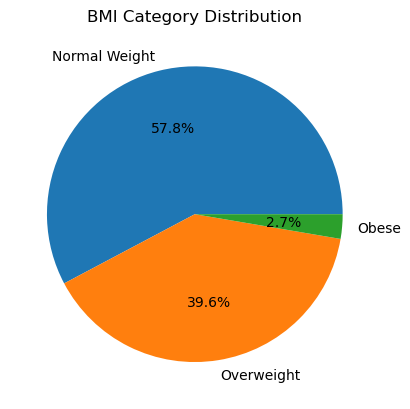

Gender Value Counts:
 Gender
Male      189
Female    185
Name: count, dtype: int64
BMI Category Value Counts:
 BMI Category
Normal Weight    216
Overweight       148
Obese             10
Name: count, dtype: int64
Sleep Disorder Value Counts:
 Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64
Occupation Value Counts:
 Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64


In [3]:
# Identify numerical and categorical features
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

# Visualize BMI Category distribution
df['BMI Category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('BMI Category Distribution')
plt.ylabel('')
plt.show()

# Check value counts for categorical features
print("Gender Value Counts:\n", df['Gender'].value_counts())
print("BMI Category Value Counts:\n", df['BMI Category'].value_counts())
print("Sleep Disorder Value Counts:\n", df['Sleep Disorder'].value_counts())
print("Occupation Value Counts:\n", df['Occupation'].value_counts())

In [4]:
# Create separate LabelEncoders for each categorical feature
gender_encoder = LabelEncoder()
bmi_encoder = LabelEncoder()
sleep_disorder_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()

# Encode categorical features
df['Gender'] = gender_encoder.fit_transform(df['Gender'])
df['BMI Category'] = bmi_encoder.fit_transform(df['BMI Category'])
df['Sleep Disorder'] = sleep_disorder_encoder.fit_transform(df['Sleep Disorder'])
df['Occupation'] = occupation_encoder.fit_transform(df['Occupation'])

# Drop 'Person ID' as it's not needed for modeling
df.drop('Person ID', axis=1, inplace=True)

# Define features (X) and target (y)
X = df[['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
        'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
        'Daily Steps', 'Systolic Pressure', 'Diastolic Pressure']]
y = df['Sleep Disorder']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display the first few rows of scaled X_train
pd.DataFrame(X_train, columns=X.columns).head()

X_train shape: (299, 12)
X_test shape: (75, 12)


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic Pressure,Diastolic Pressure
0,1.044466,0.055811,1.052791,-0.833457,-1.155098,-0.728644,0.956601,1.208787,0.481081,-0.554643,0.186918,0.050678
1,1.044466,-1.111141,-0.900371,-1.468533,-1.155098,-1.450369,1.522984,-0.844777,0.481081,-1.180447,-0.448177,-0.746830
2,1.044466,-0.877751,1.703845,0.436694,0.537913,-0.006920,-0.176166,-0.844777,-0.014076,0.696966,-1.083272,-0.746830
3,-0.957427,1.922934,0.401737,1.325801,1.384419,0.714805,-1.308933,1.208787,-0.509234,0.071162,1.457107,1.645692
4,-0.957427,-1.577922,0.401737,-0.833457,-2.001604,-0.969219,0.956601,-0.844777,2.461710,-1.806251,0.440955,0.369681


In [5]:
# Compute class weights to handle imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

# For models that don't support class_weight directly (e.g., Gradient Boosting), use sample weights
sample_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

Class Weights: {0: 1.633879781420765, 1: 0.5662878787878788, 2: 1.60752688172043}


In [6]:
# Hyperparameter tuning for Logistic Regression
logistic_params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"]
}
logistic_model = LogisticRegression(max_iter=5000)
logistic_random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=logistic_params,
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1
)
logistic_random_search.fit(X_train, y_train)

# Best hyperparameters
best_logistic_params = logistic_random_search.best_params_
print("Best Parameters for Logistic Regression:", best_logistic_params)

# Train the best model with class weights
best_logistic_model = LogisticRegression(**best_logistic_params, max_iter=5000, class_weight=class_weight_dict)
best_logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = best_logistic_model.predict(X_test)

# Evaluate
print("🚀 Logistic Regression Model Performance")
print(classification_report(y_test, y_pred, target_names=sleep_disorder_encoder.classes_))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("=" * 40, "\n")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Logistic Regression: {'solver': 'saga', 'penalty': 'l1', 'C': 10}
🚀 Logistic Regression Model Performance
              precision    recall  f1-score   support

    Insomnia       0.78      0.88      0.82        16
        None       0.95      0.95      0.95        43
 Sleep Apnea       0.93      0.81      0.87        16

    accuracy                           0.91        75
   macro avg       0.89      0.88      0.88        75
weighted avg       0.91      0.91      0.91        75

Accuracy: 0.9067
F1 Score: 0.9072
Precision: 0.9107
Recall: 0.9067



In [7]:
# Hyperparameter tuning for Random Forest
rf_params = {
    "max_depth": [5, 8, 15, None, 10],
    "max_features": [5, 7, "sqrt", "log2"],
    "min_samples_split": [2, 8, 15],
    "n_estimators": [100, 200]
}
rf_model = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

# Best hyperparameters
best_rf_params = rf_random_search.best_params_
print("Best Parameters for Random Forest:", best_rf_params)

# Train the best model with class weights
best_rf_model = RandomForestClassifier(**best_rf_params, class_weight=class_weight_dict)
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate
print("🌳 Random Forest Model Performance")
print(classification_report(y_test, y_pred, target_names=sleep_disorder_encoder.classes_))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("=" * 40, "\n")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_depth': 5}
🌳 Random Forest Model Performance
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75

Accuracy: 0.8800
F1 Score: 0.8785
Precision: 0.8819
Recall: 0.8800



In [13]:
# Hyperparameter tuning for Gradient Boosting
gradient_params = {
    "loss": ["log_loss"],
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": [2, 8, 15],
    "n_estimators": [100, 200],
    "max_depth": [5, 8, 15, None]
}
gb_model = GradientBoostingClassifier()
gb_random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gradient_params,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1
)
gb_random_search.fit(X_train, y_train)

# Best hyperparameters
best_gb_params = gb_random_search.best_params_
print("Best Parameters for Gradient Boosting:", best_gb_params)

# Train the best model with sample weights
best_gb_model = GradientBoostingClassifier(**best_gb_params)
# Map class weights to each sample
sample_weights = np.array([class_weights[label] for label in y_train])
print("Sample Weights Shape:", sample_weights.shape)  # Should be (299,)
best_gb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Evaluate
print("🔥 Gradient Boosting Model Performance")
print(classification_report(y_test, y_pred, target_names=sleep_disorder_encoder.classes_))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("=" * 40, "\n")

c:\Users\Vikash\.conda\envs\myenv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5, 'loss': 'log_loss', 'criterion': 'friedman_mse'}
Sample Weights Shape: (299,)
🔥 Gradient Boosting Model Performance
              precision    recall  f1-score   support

    Insomnia       0.68      0.81      0.74        16
        None       0.95      0.88      0.92        43
 Sleep Apnea       0.69      0.69      0.69        16

    accuracy                           0.83        75
   macro avg       0.77      0.79      0.78        75
weighted avg       0.84      0.83      0.83        75

Accuracy: 0.8267
F1 Score: 0.8301
Precision: 0.8373
Recall: 0.8267



In [9]:
# Hyperparameter tuning for Decision Tree
dt_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
dt_model = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_params,
    cv=5,
    n_jobs=-1,
    verbose=2
)
dt_grid_search.fit(X_train, y_train)

# Best hyperparameters
best_dt_params = dt_grid_search.best_params_
print("Best Parameters for Decision Tree:", best_dt_params)

# Train the best model with class weights
best_dt_model = DecisionTreeClassifier(**best_dt_params, class_weight=class_weight_dict)
best_dt_model.fit(X_train, y_train)

# Make predictions
y_pred = best_dt_model.predict(X_test)

# Evaluate
print("🌲 Decision Tree Model Performance")
print(classification_report(y_test, y_pred, target_names=sleep_disorder_encoder.classes_))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("=" * 40, "\n")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
🌲 Decision Tree Model Performance
              precision    recall  f1-score   support

    Insomnia       0.74      0.88      0.80        16
        None       0.95      0.95      0.95        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.85      0.84      0.84        75
weighted avg       0.88      0.88      0.88        75

Accuracy: 0.8800
F1 Score: 0.8792
Precision: 0.8844
Recall: 0.8800



In [10]:
# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm_tuned = GridSearchCV(
    SVC(probability=True),  # Enable predict_proba
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
svm_tuned.fit(X_train, y_train)

# Best hyperparameters
best_svm_params = svm_tuned.best_params_
print("Best Parameters for SVM:", best_svm_params)

# Train the best model with class weights
best_svm_model = SVC(**best_svm_params, class_weight=class_weight_dict, probability=True)
best_svm_model.fit(X_train, y_train)

# Make predictions
y_pred = best_svm_model.predict(X_test)

# Evaluate
print("🛠️ SVM Model Performance")
print(classification_report(y_test, y_pred, target_names=sleep_disorder_encoder.classes_))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("=" * 40, "\n")

Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
🛠️ SVM Model Performance
              precision    recall  f1-score   support

    Insomnia       0.78      0.88      0.82        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.92      0.75      0.83        16

    accuracy                           0.91        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.91      0.91      0.91        75

Accuracy: 0.9067
F1 Score: 0.9058
Precision: 0.9101
Recall: 0.9067



In [14]:
# Save the models
pickle.dump(best_logistic_model, open("logistic_model.pkl", "wb"))
pickle.dump(best_rf_model, open("random_forest_model.pkl", "wb"))
pickle.dump(best_gb_model, open("gradient_boosting_model.pkl", "wb"))
pickle.dump(best_dt_model, open("decision_tree_model.pkl", "wb"))
pickle.dump(best_svm_model, open("svm_model.pkl", "wb"))

# Save the scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

# Save the LabelEncoders
pickle.dump(sleep_disorder_encoder, open("sleep_disorder_encoder.pkl", "wb"))
pickle.dump(occupation_encoder, open("occupation_encoder.pkl", "wb"))

# Save the feature names
feature_names = X.columns.tolist()
pickle.dump(feature_names, open("feature_names.pkl", "wb"))

# Print feature names for reference
print("Feature Names:", feature_names)
print("Number of Features:", len(feature_names))

Feature Names: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic Pressure', 'Diastolic Pressure']
Number of Features: 12
